In [1]:
from collections import Counter
import math
import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np

sys.path.insert(1, './setup/')
from gp.hw.program import Program
from gp.contexts.symbolic_regression.primitive_sets import \
    nicolau_a, nicolau_b, nicolau_c

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = 5.85, 4.135
# matplotlib.rcParams['figure.figsize'] = 11.7, 8.27
# style.use('seaborn-poster')

# Useful directory paths.
root_dir = f'{os.getcwd()}/../results'
graphics_dir = f'{root_dir}/graphics'

# GP tools.
tools = ('DEAP', 'TensorGP (CPU)', 'TensorGP (GPU)', 'Operon', 'FPGA')

# Primitive sets.
primitive_sets = {
    'nicolau_a': nicolau_a,
    'nicolau_b': nicolau_b,
    'nicolau_c': nicolau_c,
}

# Program tree depth constraints for each primitive set.
d = (9, 7, 7)

# Numbers of fitness cases.
n_fitness_cases = (10, 100,)
# n_fitness_cases = (10, 100, 1000, 10000, 100000)

# Number of program bins.
n_bins = 32

# Number of programs per bin.
n_programs = 512

# Number of times in which experiments are run.
n_runs = 1

# Load programs and input/target data.
with open(f'{root_dir}/programs.pkl', 'rb') as f:
    programs = pickle.load(f)
with open(f'{root_dir}/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)
with open(f'{root_dir}/target.pkl', 'rb') as f:
    target = pickle.load(f)
inputs = np.asarray(inputs)
target = np.asarray(target)

### Compute some statistics for the set of random programs generated for each primitive set.

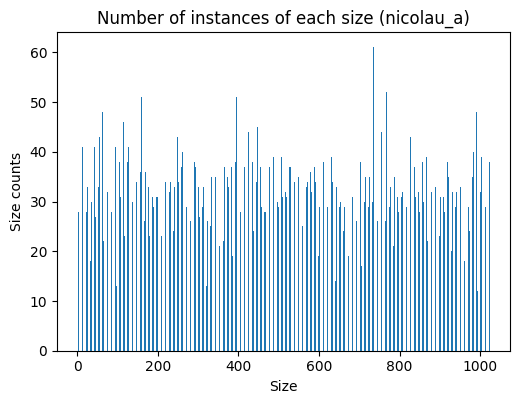

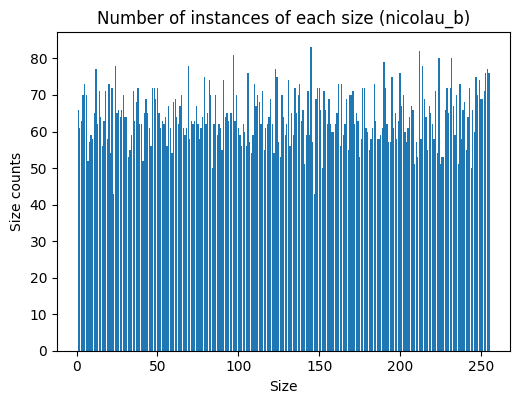

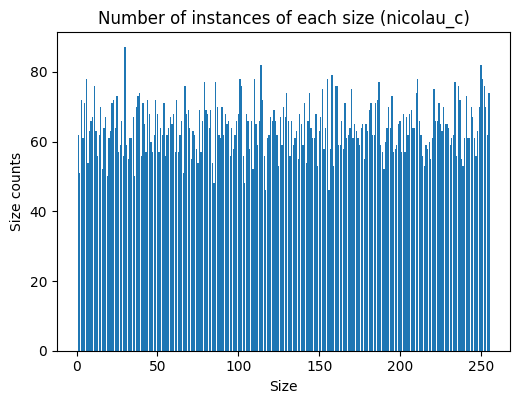

In [2]:
# Sizes of each program for every program bin, for each primitive set.
sizes = []

# Total number of nodes for each program bin, for each primitive set.
n_nodes = []

for (name, ps), d_ in zip(primitive_sets.items(), d):
    # For each primitive set...

    # Depth/size constraints relevant to primitive set.
    d_min = 0
    d_max = d_
    s_min = 1
    s_max = Program.max_size(ps.m, d_max)
    
    # Size statistics relevant to primitive set.
    sizes.append([])
    n_nodes.append([])
    for i, program_bin in enumerate(programs[name]):
        # For each program bin...
        sizes_ = [len(p) for p in program_bin]
        sizes[-1].extend(sizes_)
        n_nodes[-1].append(sum(sizes_))

    # Plot program size distribution across all program bins.
    c = Counter(sizes[-1])
    sizes_ = [c[s] if s in c else 0 for s in range(s_min, s_max + 1)]
    plt.bar(range(s_min, s_max + 1), sizes_)
    plt.xlabel('Size')
    plt.ylabel('Size counts')
    plt.title('Number of instances of each size ('+name+')')
    # plt.savefig(f'{graphics_dir}/{name}/sizes.png')
    # plt.savefig(f'{graphics_dir}/{name}/sizes.svg')
    plt.show()

# Convert `n_nodes` to NumPy array.
n_nodes = np.asarray(n_nodes)

### Extract runtimes for all experiments, for each GP tool.

In [3]:
# Runtimes for each program bin, for each number of fitness 
# cases, for each primitive set, for each tool.
runtimes = []

# Load runtimes for DEAP.
with open(f'{root_dir}/runtimes/deap/results.pkl', 'rb') as f:
    runtimes_ = pickle.load(f)
runtimes.append(np.array([[[r for r in runtimes_[i][j]] for j in range(
    len(n_fitness_cases))] for i in range(len(primitive_sets))]))

# Load runtimes for TensorGP.
with open(f'{root_dir}/runtimes/tensorgp/results.pkl', 'rb') as f:
    runtimes_ = pickle.load(f)
for i, _ in enumerate(('CPU', 'GPU')):
    runtimes.append(np.array([[[r for r in runtimes_[i][j][k]] for k in range(
        len(n_fitness_cases))] for j in range(len(primitive_sets))]))

# Load runtimes for Operon.
runtimes_ = []
for name in primitive_sets:
    # For each primitive set...
    runtimes_.append([])
    with open(f'{root_dir}/runtimes/operon/{name}.csv', 'r') as f:
        lines = f.readlines()
    for nfc in n_fitness_cases:
        # For each number of fitness cases...
        runtimes_[-1].append([])
        # Index offset into the `lines` list.
        i = (int(math.log(nfc, 10)) - 1) * n_bins
        for j in range(1, n_bins + 1):
            # For each program bin...
            # String representing runtimes for bin `j`, 
            # in terms of microseconds.
            s = ''.join(lines[i + j - 1].split())
            runtimes_[-1][-1].append([float(r)/(10**6) for r in s.split(',')])
runtimes.append(np.array(runtimes_))

# Load runtimes for the FPGA architecture.
runtimes_ = []
for name in primitive_sets:
    # For each primitive set...
    runtimes_.append([])
    for nfc in n_fitness_cases:
        # For each number of fitness cases...
        with open(f'{root_dir}/runtimes/fpga/{name}/{nfc}.txt', 'r') as f:
            # Lines of the current file.
            lines = f.readlines()
            # Clock frequency for the relevant run.
            clock_freq = float(lines[0])*1e6
            # Runtimes relevant to the number of fitness cases.
            runtimes_[-1].append([[float(n_cycles) / clock_freq] 
                for n_cycles in lines[1:]])
runtimes.append(np.tile(np.array(runtimes_), (1, 1, 1, n_runs)))

# Convert the tool runtimes to a NumPy array.
runtimes = np.stack([r for r in runtimes])

# Median runtimes for each program bin, for each number of fitness 
# cases, for each primitive set, for each tool, for each function set.
median_runtimes = [[[[np.median(runtimes[i][j][k][l]) 
    for l in range(n_bins)]
    for k in range(len(n_fitness_cases))] 
    for j in range(len(primitive_sets))]
    for i in range(len(tools))]
median_runtimes = np.asarray(median_runtimes)

# Compute node evaluations per second (NEPS) for each runtime, 
# for each program bin, for each number of fitness cases, for each 
# primitive set, for each tool.
neps = np.array([[np.dstack([n_nodes[j]] * n_runs) / runtimes[i][j]
    for j in range(len(primitive_sets))] for i in range(len(tools))])

# Median NEPS for each program bin, for each number of fitness 
# cases, for each primitive set, for each tool, for each function set.
# (Note that, for each program bin, the following calculation is 
# equivalent to dividing the relevant number of nodes within each 
# program bin by the relevant median runtime corresponding to the bin.)
median_neps = [[[[np.median(neps[i][j][k][l]) 
    for l in range(n_bins)]
    for k in range(len(n_fitness_cases))] 
    for j in range(len(primitive_sets))]
    for i in range(len(tools))]
median_neps = np.asarray(median_neps)

### Compute an average FPGA speedup (in terms of NEPS) across all program bins, for an increasing sequence of "number of fitness case" thresholds.

In [4]:
# Total median runtimes across all primitive sets, 
# for each fitness case threshold, for each tool.
total_median_runtimes = np.asarray(
    [[np.sum(median_runtimes[t, :, :n+1])
        for n, _ in enumerate(n_fitness_cases)] 
            for t, _ in enumerate(tools)])

print(f'\nTotal median runtimes:\n{total_median_runtimes}\n')
print(f'\nTotal median runtimes shape:\n{total_median_runtimes.shape}\n')

print(f'\nNum nodes:\n{n_nodes}\n')
print(f'\nNum nodes shape:\n{n_nodes.shape}\n')

# Total number of program nodes across all primitive sets,
# for each fitness case threshold.
total_nodes = np.asarray(
    [np.sum([fc * n_nodes for fc in n_fitness_cases[:n+1]])
        for n, _ in enumerate(n_fitness_cases)])

print(f'\nTotal nodes:\n{total_nodes}\n')
print(f'\nTotal nodes shape:\n{total_nodes.shape}\n')

# Total median NEPS for each fitness case threshold, for each tool.
total_neps = total_nodes / total_median_runtimes

print(f'\nTotal NEPS:\n{total_neps}\n')
print(f'\nTotal NEPS shape:\n{total_neps.shape}\n')

# Average FPGA speedup for each fitness case threshold.
avg_fpga_speedup = total_neps[-1, :] / total_neps[:-1, :]

print(f'\nAverage FPGA Speedup:\n{avg_fpga_speedup}\n')
print(f'\nAverage FPGA Speedup shape:\n{avg_fpga_speedup.shape}\n')


Total median runtimes:
[[1.08165935e+02 4.12755880e+02]
 [3.96638397e+02 8.25517511e+02]
 [4.20294038e+02 8.42980078e+02]
 [1.02709863e+00 2.05688920e+00]
 [2.14652746e-02 8.60404746e-01]]


Total median runtimes shape:
(5, 2)


Num nodes:
[[  8782  25170  41180  58062  74158  90508 106874 123360 139064 155800
  172664 188626 205092 221694 238008 254438 270670 287208 303576 320114
  336372 352522 369324 385744 401812 417908 434758 451144 467670 483554
  500222 516380]
 [  2262   6406  10490  14547  18724  22850  26811  30994  35056  39189
   43222  47383  51358  55605  59646  63746  67868  71879  75984  80075
   84181  88225  92385  96576 100666 104701 108901 112958 117162 121102
  125254 129053]
 [  2329   6334  10541  14571  18722  22735  26835  30949  35054  39252
   43267  47340  51426  55541  59580  63730  67788  71987  76081  80171
   84194  88279  92435  96419 100576 104745 108695 112980 116959 121021
  125135 128988]]


Num nodes shape:
(3, 32)


Total nodes:
[ 126123760 13873

### Plot median NEPS point estimates versus program bin number (and a corresponding maximum size) for each tool, for each combination of function set and number of fitness cases.

#### **NOTE:** In total, there are fifteen separate plots, one for each combination of function set and number of fitness cases.



Function set nicolau_a, 10 cases...




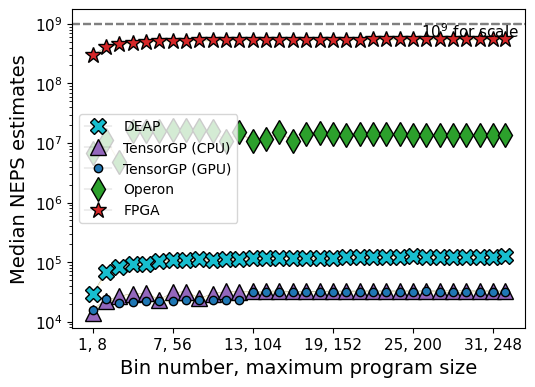



Function set nicolau_a, 100 cases...




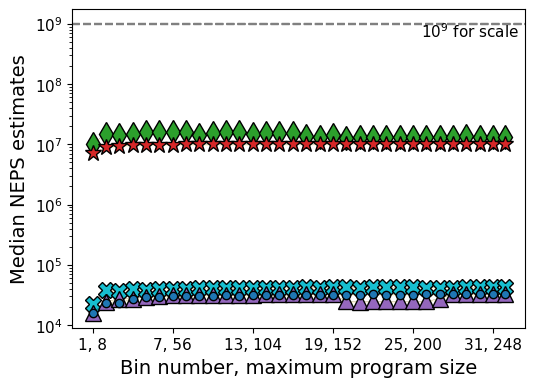



Function set nicolau_b, 10 cases...




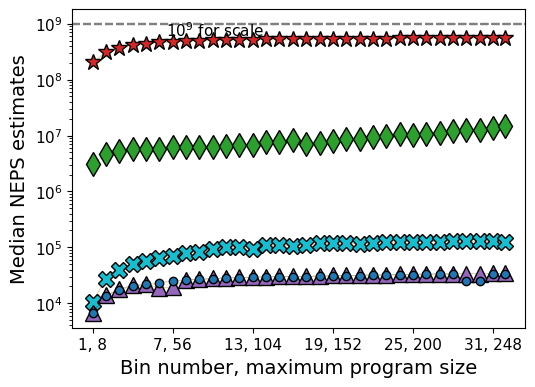



Function set nicolau_b, 100 cases...




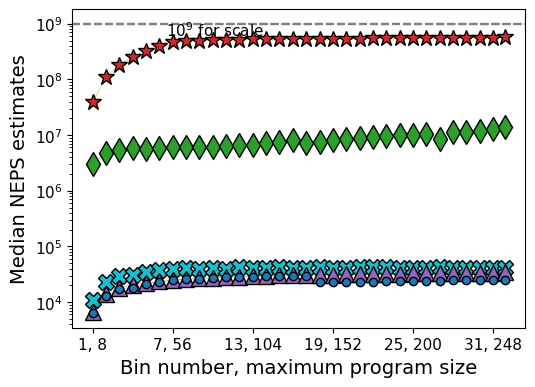



Function set nicolau_c, 10 cases...




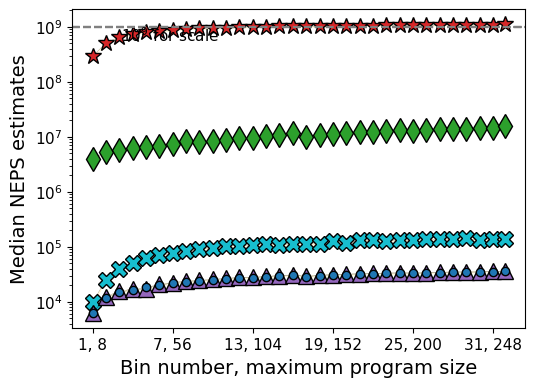



Function set nicolau_c, 100 cases...




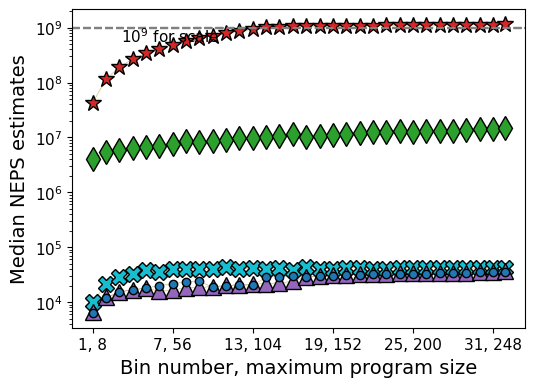

In [9]:
colors = ('tab:cyan', 'tab:purple', 'tab:blue', 'tab:green', 'tab:red')
markers = ('X', '^', '.', 'd', '*')
marker_sizes = (6, 4, 8, 5, 9)
print_legend = ((True, False, False, False, False),
                (False, False, False, False, False),
                (False, False, False, False, False))
scale_text_x = ((205, 205, 205, 205, 205),
                (52, 52, 52, 52, 52),
                (25, 25, 25, 25, 25))
scale_text_y = ((0.5e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (0.5e9, 0.5e9, 0.5e9, 1.25e9, 6e8),
                (0.45e9, 0.5e9, 0.5e9, 1.25e9, 5.5e8))

for j, ((name, ps), d_) in enumerate(zip(primitive_sets.items(), d)):
    # For each primitive set...

    # Maximum possible program size for the given depth constraint.
    s_max_possible = Program.max_size(ps.m, d_max)

    # Number of unique sizes per program bin (except possibly the last).
    n_sizes = math.ceil(s_max / n_bins)

    # Indices for the plots associated with the current primitive set.
    index = [s_max_possible if i == n_bins - 1 else (i + 1) * n_sizes
        for i in range(n_bins)]
    index_ = [i for i in range(1, n_bins + 1)]

    for k, nfc in enumerate(n_fitness_cases):
        # For each number of fitness cases...
        print(f'\n\nFunction set {name}, {nfc} cases...\n\n')

        for i, tool in enumerate(tools):
            # For each tool...
            x = index
            y = median_neps[i][j][k]
            
            # 25th and 75th NEPS percentiles for each program bin.
            percentile_25 = np.percentile(neps[i][j][k], 25, axis=1)
            percentile_75 = np.percentile(neps[i][j][k], 75, axis=1)
            iqr = percentile_75 - percentile_25
            lower_bound = [y_ - p_ if iqr_ != 0 else y_ 
                for y_, p_, iqr_ in zip(y, percentile_25, iqr)]
            upper_bound = [y_ + p_ if iqr_ != 0 else y_
                for y_, p_, iqr_ in zip(y, percentile_75, iqr)]

            plt.plot(
                x, y, label=f'{tool}', markerfacecolor=colors[i], 
                marker=markers[i], markersize=12, color='black', linewidth=0.1)
            plt.axhline(y=1e9, color='gray', linestyle='dashed')
            plt.fill_between(
                x, lower_bound, upper_bound, interpolate=True, 
                color='cornsilk')

        plt.text(
            scale_text_x[j][i], scale_text_y[j][i], '$10^9$ for scale', 
            weight='normal', fontsize = 11)

        plt.xlabel('Bin number, maximum program size', fontsize=14)
        plt.xticks(index, [f'{str(ind_)}, {str(ind)}' 
            for ind, ind_ in zip(index, index_)], fontsize=11)
        plt.yticks(fontsize=11)
        plt.locator_params(axis='x', nbins=6)
        plt.ylabel('Median NEPS estimates', fontsize=14)
        plt.yscale('log')
        if print_legend[j][k]:
            plt.legend(loc='center left')
        # plt.savefig(f'{graphics_dir}/{name}/median_neps_{nfc}.svg')
        # plt.savefig(f'{graphics_dir}/{name}/median_neps_{nfc}.png', dpi=600)
        plt.show()